# Seq2Seq: _Multivariate, Multi-step_ architectures - LSTM & GRU with TF2.8

#### Metro Interstate Traffic Volume Data Set

__Abstract:__ Hourly Minneapolis-St Paul, MN traffic volume for westbound I-94. Includes weather and holiday features from 2012-2018.

__Data Set Information:__
Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.


Attribute Information:

1. holiday Categorical US National holidays plus regional holiday, Minnesota State Fair
2. temp Numeric Average temp in kelvin
3. rain_1h Numeric Amount in mm of rain that occurred in the hour
4. snow_1h Numeric Amount in mm of snow that occurred in the hour
5. clouds_all Numeric Percentage of cloud cover
6. weather_main Categorical Short textual description of the current weather
7. weather_description Categorical Longer textual description of the current weather
8. date_time DateTime Hour of the data collected in local CST time
9. traffic_volume Numeric Hourly I-94 ATR 301 reported westbound traffic volume


Refer-
https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume


In [ ]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense, LSTM, GRU, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [3]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

No GPU found


In [4]:
# Read processed data-
data = pd.read_csv("Metro_Interstate_Traffic_Volume_processed.csv", low_memory = False)

In [5]:
data.shape

(48204, 6)

In [6]:
# Get data types-
data.dtypes

temp              float64
rain_1h           float64
snow_1h           float64
clouds_all          int64
traffic_volume      int64
date_time          object
dtype: object

In [7]:
# Convert 'date_time' attribute to datetime, sort & reset indices-
data['date_time'] = pd.to_datetime(data['date_time'])
data.sort_values(by = 'date_time', ascending = True, inplace = True)
data.reset_index(drop = True, inplace = True)

In [8]:
# Sanity check-
data.dtypes

temp                     float64
rain_1h                  float64
snow_1h                  float64
clouds_all                 int64
traffic_volume             int64
date_time         datetime64[ns]
dtype: object

In [9]:
# Use standard scaler-
std_scaler = StandardScaler()
data_scaled = std_scaler.fit_transform(data.iloc[:, :-1])

In [10]:
# Sanity check-
data.shape, data_scaled.shape

((48204, 6), (48204, 5))

In [11]:
data_scaled[:5, :]

array([[ 0.55205015, -0.00746314, -0.02722834, -0.23996279,  1.15015883],
       [ 0.63703499, -0.00746314, -0.02722834,  0.65712012,  0.63225101],
       [ 0.65434672, -0.00746314, -0.02722834,  1.04158422,  0.75858227],
       [ 0.69762604, -0.00746314, -0.02722834,  1.04158422,  0.88894002],
       [ 0.77710261, -0.00746314, -0.02722834,  0.65712012,  0.83458235]])

In [12]:
# Split data into training and validation datasets. Ratio is
# 90:10-
len(data_scaled[: int(len(data_scaled) * 0.9)]), len(data_scaled[int(len(data_scaled) * 0.9): ])

(43383, 4821)

In [13]:
# Sanity check-
len(data_scaled[: int(len(data_scaled) * 0.9)]) + len(data_scaled[int(len(data_scaled) * 0.9): ]) == len(data_scaled)

True

In [19]:
train_data = data_scaled[: int(len(data_scaled) * 0.9), :]
test_data = data_scaled[int(len(data_scaled) * 0.9):, :]

In [20]:
# Sanity check-
train_data.shape, test_data.shape

((43383, 5), (4821, 5))

In [21]:
# Further sanity check-
train_data[-5:, :]

array([[-0.79669083, -0.00746314, -0.02722834, -1.13704571,  1.21659599],
       [-0.63852459, -0.00746314, -0.02722834, -1.13704571,  0.60205231],
       [-0.57163837, -0.00746314, -0.02722834, -1.23956947,  0.73241006],
       [-0.48744042, -0.00746314, -0.02722834, -1.23956947,  0.85672807],
       [-0.41504592, -0.00746314, -0.02722834, -1.13704571,  0.83206579]])

In [22]:
test_data[:5, :]

array([[-0.36625833, -0.00746314, -0.02722834, -1.23956947,  0.9865825 ],
       [-0.28992934, -0.00746314, -0.02722834, -1.23956947,  1.30064905],
       [-0.23327278, -0.00746314, -0.02722834, -1.13704571,  1.70984153],
       [-0.19078036, -0.00746314, -0.02722834, -1.13704571,  1.51858305],
       [-0.16009139, -0.00746314, -0.02722834, -0.23996279,  0.78878098]])

In [23]:
data_scaled[43378:43388, :]

array([[-0.79669083, -0.00746314, -0.02722834, -1.13704571,  1.21659599],
       [-0.63852459, -0.00746314, -0.02722834, -1.13704571,  0.60205231],
       [-0.57163837, -0.00746314, -0.02722834, -1.23956947,  0.73241006],
       [-0.48744042, -0.00746314, -0.02722834, -1.23956947,  0.85672807],
       [-0.41504592, -0.00746314, -0.02722834, -1.13704571,  0.83206579],
       [-0.36625833, -0.00746314, -0.02722834, -1.23956947,  0.9865825 ],
       [-0.28992934, -0.00746314, -0.02722834, -1.23956947,  1.30064905],
       [-0.23327278, -0.00746314, -0.02722834, -1.13704571,  1.70984153],
       [-0.19078036, -0.00746314, -0.02722834, -1.13704571,  1.51858305],
       [-0.16009139, -0.00746314, -0.02722834, -0.23996279,  0.78878098]])

In [24]:
def split_series(data, n_past, n_future):
    '''
    Create training and testing splits required by Seq2Seq
    architecture(s).
    '''
    X, y = list(), list()
    
    for window_start in range(len(data)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(data):
            break
            
        # slice past and future parts of window-
        # past, future = data[window_start: past_end, :], data[past_end: future_end, :]
        past, future = data[window_start: past_end, :], data[past_end: future_end, 4]
        X.append(past)
        y.append(future)
        
    return np.array(X), np.array(y)


In [25]:
# Define hyper-parameters-
n_past = 10
n_future = 5 
n_features = 5

In [26]:
X_train, y_train = split_series(train_data, n_past, n_future)
X_test, y_test = split_series(test_data, n_past, n_future)

In [27]:
# Sanity check-
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (43369, 10, 5), y_train.shape: (43369, 5)
X_test.shape: (4807, 10, 5), y_test.shape: (4807, 5)


### Define _Seq2Seq_ architectures: LSTM & GRU

In [58]:
def Single_LSTM(X, y):
    '''
    Define a single layer LSTM architecture.
    '''
    model = Sequential()

    model.add(
        LSTM(
            units = 64, activation = tf.keras.activations.tanh,
            input_shape = (X.shape[1], X.shape[2]),
            return_sequences = False
        )
    )
    
    model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model


In [59]:
def Single_GRU(X, y):
    '''
    Define a single layer LSTM architecture.
    '''
    model = Sequential()

    model.add(
        GRU(
            units = 64, activation = tf.keras.activations.tanh,
            input_shape = (X.shape[1], X.shape[2]),
            return_sequences = False
        )
    )
    
    model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model


In [33]:
# Initialize an instance-
model_single_lstm = Single_LSTM(X = X_train, y = y_train)

In [60]:
model_single_gru = Single_GRU(X = X_train, y = y_train)

In [34]:
# Sanity check-
y_pred = model_single_lstm(X_train[:5, :])

In [37]:
print(f"Single layer LSTM output shape: {y_pred.shape}")

Single layer LSTM output shape: (5, 5)


In [36]:
y_pred.shape, y_train[:5].shape

(TensorShape([5, 5]), (5, 5))

In [61]:
# Sanity check-
y_pred_gru = model_single_gru(X_train[:5, :])

In [62]:
print(f"Single layer GRU output shape: {y_pred_gru.shape}")

Single layer GRU output shape: (5, 5)


In [64]:
y_pred_gru.shape, y_train[:5].shape

(TensorShape([5, 5]), (5, 5))

In [38]:
# Get model summary-
model_single_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 18,245
Trainable params: 18,245
Non-trainable params: 0
_________________________________________________________________


In [65]:
model_single_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                13632     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 13,957
Trainable params: 13,957
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Compile defined model-
model_single_lstm.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [66]:
model_single_gru.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [40]:
# Define early stopping criterion-
early_stopping_criterion = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", min_delta = 0.001,
    patience = 5, verbose = 0,
    mode = "auto", baseline = None,
    restore_best_weights = True,
)

In [42]:
# Train single-layer LSTM model-
train_history_lstm = model_single_lstm.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 128,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
339/339 [==============================] - 4s 8ms/step - loss: 0.3422 - val_loss: 0.2187
Epoch 2/50
339/339 [==============================] - 2s 6ms/step - loss: 0.2475 - val_loss: 0.1556
Epoch 3/50
339/339 [==============================] - 2s 6ms/step - loss: 0.2250 - val_loss: 0.1803
Epoch 4/50
339/339 [==============================] - 2s 6ms/step - loss: 0.2133 - val_loss: 0.1461
Epoch 5/50
339/339 [==============================] - 2s 6ms/step - loss: 0.2046 - val_loss: 0.1392
Epoch 6/50
339/339 [==============================] - 2s 6ms/step - loss: 0.1983 - val_loss: 0.1266
Epoch 7/50
339/339 [==============================] - 2s 6ms/step - loss: 0.1925 - val_loss: 0.1227
Epoch 8/50
339/339 [==============================] - 2s 6ms/step - loss: 0.1866 - val_loss: 0.1227
Epoch 9/50
339/339 [==============================] - 2s 6ms/step - loss: 0.1857 - val_loss: 0.1294
Epoch 10/50
339/339 [==============================] - 2s 7ms/step - loss: 0.1826 - val_loss: 0.1153

In [67]:
# Train single-layer GRU model-
train_history_gru = model_single_gru.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 128,
    validation_data = (X_test, y_test),
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
339/339 [==============================] - 4s 8ms/step - loss: 0.3221 - val_loss: 0.1603
Epoch 2/50
339/339 [==============================] - 2s 6ms/step - loss: 0.2405 - val_loss: 0.1489
Epoch 3/50
339/339 [==============================] - 2s 6ms/step - loss: 0.2243 - val_loss: 0.1466
Epoch 4/50
339/339 [==============================] - 2s 6ms/step - loss: 0.2128 - val_loss: 0.1658
Epoch 5/50
339/339 [==============================] - 2s 6ms/step - loss: 0.2101 - val_loss: 0.1348
Epoch 6/50
339/339 [==============================] - 2s 6ms/step - loss: 0.2033 - val_loss: 0.1388
Epoch 7/50
339/339 [==============================] - 2s 6ms/step - loss: 0.1972 - val_loss: 0.1312
Epoch 8/50
339/339 [==============================] - 2s 6ms/step - loss: 0.1939 - val_loss: 0.1230
Epoch 9/50
339/339 [==============================] - 2s 6ms/step - loss: 0.1911 - val_loss: 0.1352
Epoch 10/50
339/339 [==============================] - 2s 6ms/step - loss: 0.1885 - val_loss: 0.1328

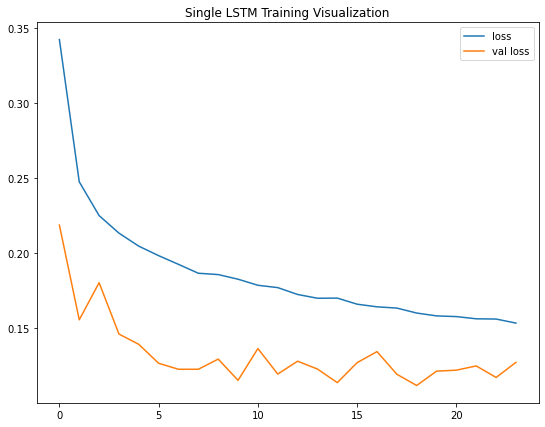

In [44]:
# Visualize training - LSTM model
plt.figure(figsize = (9, 7))
plt.plot(train_history_lstm.history['loss'], label = 'loss')
plt.plot(train_history_lstm.history['val_loss'], label = 'val loss')
plt.title("Single LSTM Training Visualization")
plt.legend(loc = 'best')
plt.show()

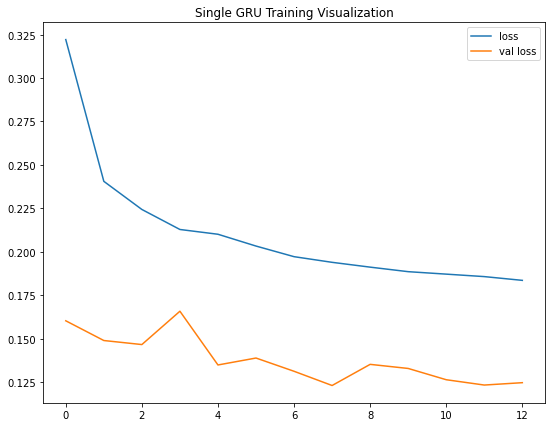

In [68]:
# Visualize training - GRU model
plt.figure(figsize = (9, 7))
plt.plot(train_history_gru.history['loss'], label = 'loss')
plt.plot(train_history_gru.history['val_loss'], label = 'val loss')
plt.title("Single GRU Training Visualization")
plt.legend(loc = 'best')
plt.show()

In [46]:
# Get predictions and ground truth for model's performance comparisons-
ground_truth_single = [y[0] for y in y_test]
predictions_single = [y_pred[0] for y_pred in model_single_lstm.predict(X_test)]

In [73]:
predictions_single_gru = [y_pred[0] for y_pred in model_single_gru.predict(X_test)]

In [74]:
# Sanity check-
len(ground_truth_single), len(predictions_single), len(predictions_single_gru)

(4807, 4807, 4807)

In [75]:
# Convert from list to np.arrays-
ground_truth_single = np.array(ground_truth_single)
predictions_single = np.array(predictions_single)
predictions_single_gru = np.array(predictions_single_gru)

In [76]:
# Sanity check-
ground_truth_single.shape, predictions_single.shape, predictions_single_gru.shape

((4807,), (4807,), (4807,))

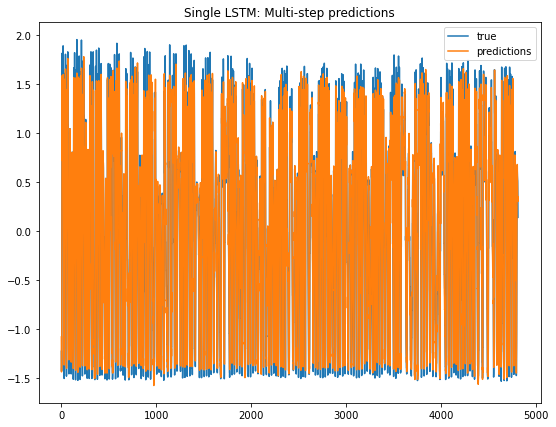

In [53]:
# Visualize predictions vs. ground truth-
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_single, label = 'predictions')
plt.title("Single LSTM: Multi-step predictions")
plt.legend(loc =  'best')
plt.show()

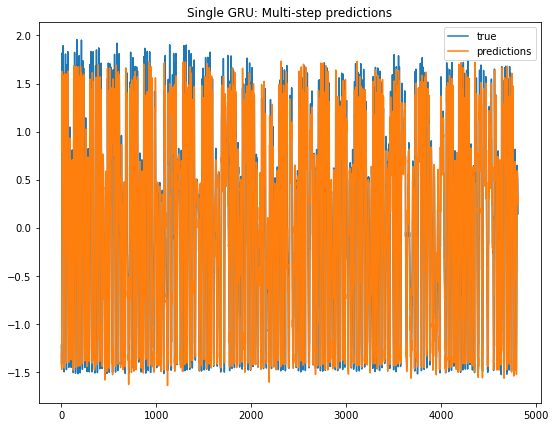

In [77]:
# Visualize predictions vs. ground truth-
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_single_gru, label = 'predictions')
plt.title("Single GRU: Multi-step predictions")
plt.legend(loc =  'best')
plt.show()

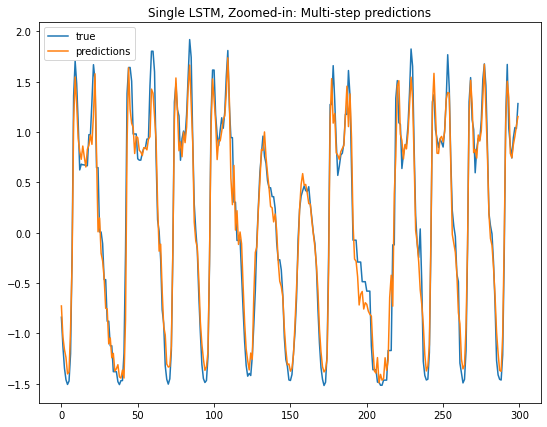

In [55]:
# Visualize predictions vs. ground truth-
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single[500:800], label = 'true')
plt.plot(predictions_single[500:800], label = 'predictions')
plt.title("Single LSTM, Zoomed-in: Multi-step predictions")
plt.legend(loc =  'best')
plt.show()

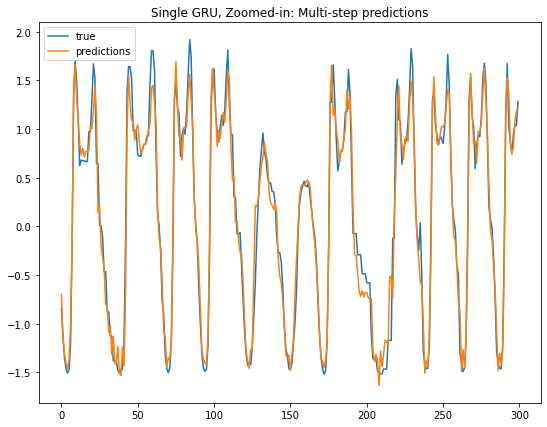

In [78]:
# Visualize predictions vs. ground truth-
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single[500:800], label = 'true')
plt.plot(predictions_single_gru[500:800], label = 'predictions')
plt.title("Single GRU, Zoomed-in: Multi-step predictions")
plt.legend(loc =  'best')
plt.show()

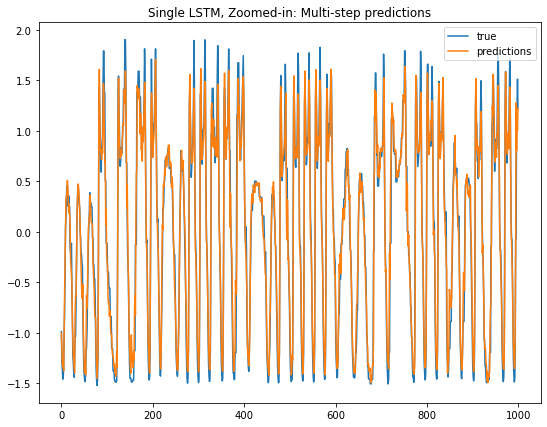

In [56]:
# Visualize predictions vs. ground truth-
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single[1000:2000], label = 'true')
plt.plot(predictions_single[1000:2000], label = 'predictions')
plt.title("Single LSTM, Zoomed-in: Multi-step predictions")
plt.legend(loc =  'best')
plt.show()

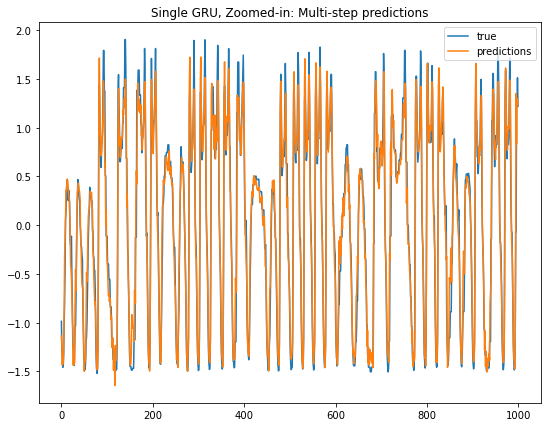

In [79]:
# Visualize predictions vs. ground truth-
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single[1000:2000], label = 'true')
plt.plot(predictions_single_gru[1000:2000], label = 'predictions')
plt.title("Single GRU, Zoomed-in: Multi-step predictions")
plt.legend(loc =  'best')
plt.show()

In [86]:
ground_truth_single.shape, predictions_single.shape, predictions_single_gru.shape

((4807,), (4807,), (4807,))

In [87]:
ground_truth_single.reshape(-1, 1).shape

(4807, 1)

In [ ]:
std_scaler.inverse_transform(ground_truth_single)

In [ ]:
# Inverse scaled values to get back original values-
ground_truth_single = std_scaler.inverse_transform(ground_truth_single.reshape(-1, 1))
predictions_single = std_scaler.inverse_transform(predictions_single.reshape(-1, 1))
predictions_single_gru = std_scaler.inverse_transform(predictions_single_gru.reshape(-1, 1))